In [1]:
import pandas as pd
from fastai.vision import *
from fastai.metrics import error_rate
%matplotlib inline

# Data locations
path = "data/"

In [2]:
df = pd.read_csv(path + "train.csv")
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [3]:
data = ImageDataBunch.from_csv(
    path, folder="train/", csv_labels="train.csv", ds_tfms=get_transforms()
).normalize(imagenet_stats)

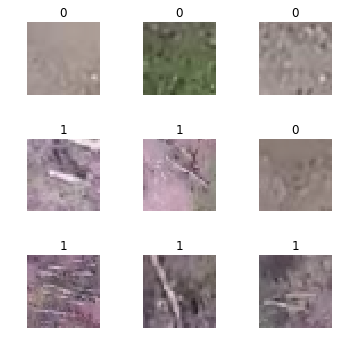

In [4]:
data.show_batch(rows=3, figsize=(5,5))

In [19]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 30041867.23it/s]


In [20]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [21]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.223159,0.135076,0.054571,00:16
1,0.135854,0.073232,0.024571,00:15
2,0.095290,0.072090,0.027143,00:14
3,0.085002,0.065921,0.024286,00:15


In [22]:
learn.save("stage-1")

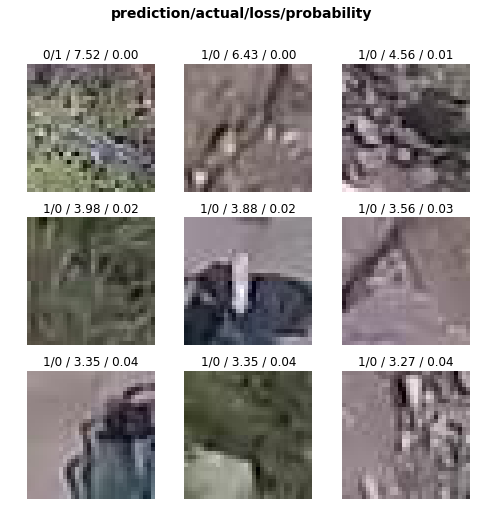

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(8, 8))

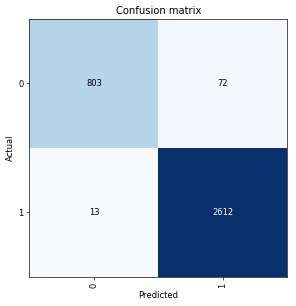

In [27]:
interp.plot_confusion_matrix(figsize=(5, 5), dpi=60)

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.057361,0.022006,0.006571,00:17


In [31]:
learn.load("stage-1");

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


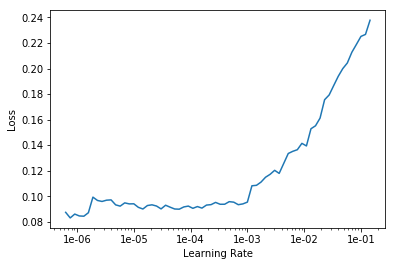

In [33]:
learn.recorder.plot()

In [34]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.075495,0.047298,0.016857,00:17
1,0.063691,0.028438,0.010857,00:17
2,0.044034,0.028003,0.011143,00:17
